In [1]:
%load_ext autoreload
%autoreload complete

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns

In [3]:
import sys; sys.path.append('..')
from brain_data import NSDBenchmark

target_regions = ['EVC','OTC']

combined_response_data = []
combined_metadata = []

for region in target_regions:
    benchmark = NSDBenchmark(*f'shared1000_{region}-only'.split('_'))
    
    response_data = benchmark.response_data.copy()
    voxel_metadata = benchmark.metadata.copy()
    
    voxel_metadata = voxel_metadata[['subj_id','ncsnr']]
    voxel_metadata['region'] = region
    
    combined_response_data.append(response_data)
    combined_metadata.append(voxel_metadata)
    
response_data = pd.concat(combined_response_data)
voxel_metadata = pd.concat(combined_metadata)

Now loading the shared1000 image set and the EVC-only voxel set...
Now loading the shared1000 image set and the OTC-only voxel set...


### Reliability (NCSNR) Mapping

In [4]:
import nibabel as nib
import cortex #pycortex

nsd_path = '/storage/colinconwell/datasets/NSD'

def get_subj_dims(subj):
    fn = f'{nsd_path}/nsddata/ppdata/{subj}/func1pt8mm/mean.nii.gz'
    return nib.load(fn).get_fdata().shape

In [5]:
subj = 'subj01'
space = 'func1pt8mm'
xfm = 'func1pt8_to_anat0pt8_autoFSbbr'
beta_version = 'betas_fithrf_GLMdenoise_RR'

In [6]:
volumetric_data = np.zeros(get_subj_dims(subj))
volumetric_data[:] = np.nan

for row_i, row in voxel_metadata.iterrows():
    subj_i, x, y, z = row.name.split('-')
    
    if f'subj0{subj_i[1]}' == subj:
        x, y, z = int(x), int(y), int(z)
        volumetric_data[x,y,z] = row.ncsnr
    
voxel_data = volumetric_data

In [7]:
from IPython.display import display
from io import BytesIO
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_ROI_flatmap(voxel_data, subj, mapper='nearest', rois = False, roi_labels = False, title = None,
                     vmin=None, vmax=None, cmap='inferno', figsize = (20,10), dpi = 100, colorbar = True):

    voxel_data = np.swapaxes(voxel_data, 0, 2)
    plot_data = cortex.Volume(voxel_data, subj, cmap=cmap, vmin=vmin,vmax=vmax, 
                              xfmname='func1pt8_to_anat0pt8_autoFSbbr')

    fig = plt.figure(figsize=figsize)
    
    cortex_handle = cortex.quickshow(
        plot_data, fig = fig, 
        dpi = dpi, recache = False,
        with_rois = rois, 
        with_labels = roi_labels, 
        with_curvature=True,
        curvature_contrast=0.1,
        curvature_brightness=0.9,
        with_colorbar = colorbar)
    
    if title:
        plt.title(title)
    
    return plot_data, fig

def convert_figure_to_image(fig, dpi=300):
    buffer = BytesIO()
    fig.savefig(buffer, format='png', dpi=dpi)
    buffer.seek(0)

    # Load image from buffer; convert to RGB
    return Image.open(buffer).convert('RGB')

In [8]:
# assess min and max values to set the range
np.nanmin(voxel_data), np.nanmax(voxel_data)

(0.0, 1.418752908706665)

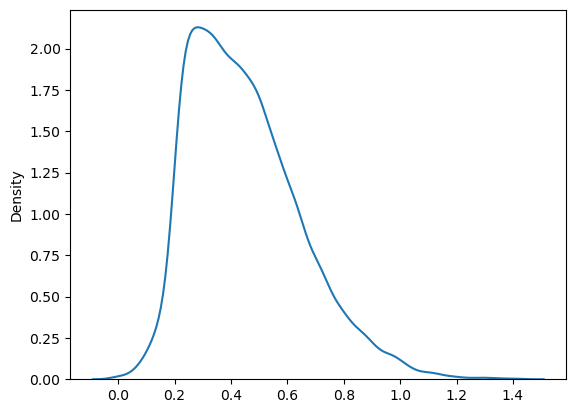

In [9]:
# overall distribution of NCSNR values
sns.kdeplot(voxel_data.flatten());

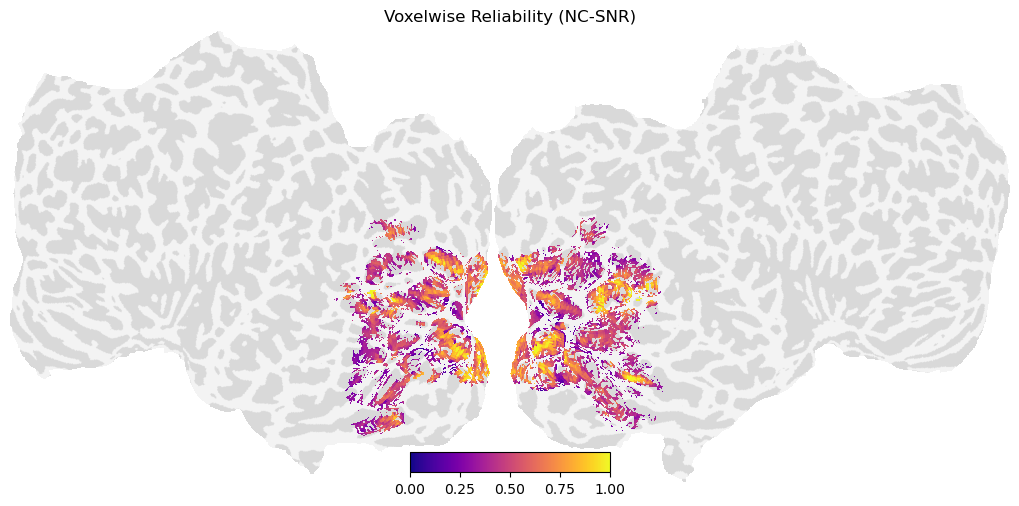

In [10]:
# Generate the plot_data and fig using plot_ROI_flatmap function
volume, fig = plot_ROI_flatmap(voxel_data, subj, figsize = (10,5), cmap = 'plasma',
                               vmin = 0, vmax = 1.0, #rois = True,
                               title = 'Voxelwise Reliability (NC-SNR)')

brain_plot = convert_figure_to_image(fig)